In [1]:
import pandas as pd
import os
from scipy.stats import pearsonr
from statsmodels.miscmodels.ordinal_model import OrderedModel
import seaborn as sns
import matplotlib.pyplot as plt
from utils import create_registry_case_identification_column, create_ehr_case_identification_column, patient_selection
from utils import load_data_from_main_dir
from lab_preprocessing import preprocess_labs
from outcome_preprocessing import preprocess_outcomes


In [2]:
eds_path = '/Users/jk1/stroke_datasets/stroke_unit_dataset/per_value/Extraction_20221117/eds_j1.csv'
ehr_data_path = '/Users/jk1/stroke_datasets/stroke_unit_dataset/per_value/Extraction_20221117/'
registry_path = '/Users/jk1/Library/CloudStorage/OneDrive-unige.ch/stroke_research/geneva_stroke_unit_dataset/data/stroke_registry/post_hoc_modified/stroke_registry_post_hoc_modified.xlsx'

In [3]:
eds_df = pd.read_csv(eds_path, delimiter=';', encoding='utf-8',
                         dtype=str)
registry_df = pd.read_excel(registry_path, dtype=str)


In [4]:
registry_df['case_admission_id'] = create_registry_case_identification_column(registry_df)
eds_df['case_admission_id'] = create_ehr_case_identification_column(eds_df)

In [5]:
eds_df.head()

nr patient_id  patient_id_gc patient_id_manual eds_end_4digit eds_manual  \
0  0     100503  non renseigné               NaN            884        NaN   
1  1    1005564  non renseigné               NaN           4109        NaN   
2  2    1005798            Oui               NaN           9217        NaN   
3  3    1011794  non renseigné               NaN             30        NaN   
4  4    1012915  non renseigné               NaN           7747        NaN   

                DOB        begin_date          end_date        death_date  \
0  31.10.1933 00:00  08.11.2018 13:21  16.11.2018 13:00               NaN   
1  11.03.1957 00:00  02.10.2018 08:11  22.10.2018 09:35               NaN   
2  15.03.1950 00:00  10.09.2018 21:36  18.09.2018 17:47               NaN   
3  23.07.1921 00:00  22.01.2018 13:13               NaN  01.02.2018 01:00   
4  29.08.1935 00:00  20.05.2018 19:07  24.05.2018 12:37               NaN   

   ...     eds_final_end eds_final_patient_id eds_final_patient_id_gc  \
0  ...  16.11.2018 18:16               100503           non renseigné   
1  ...  22.10.2018 09:35              1005564           non renseigné   
2  ...  18.09.2018 17:47              1005798                     Oui   
3  ...  01.02.2018 01:00              1011794           non renseigné   
4  ...  15.06.2018 12:39              1012915           non renseigné   

    eds_final_birth eds_final_death eds_final_birth_str  \
0               NaN             NaN                 NaN   
1  11.03.1957 00:00             NaN          11.03.1957   
2  15.03.1950 00:00             NaN          15.03.1950   
3               NaN             NaN                 NaN   
4  29.08.1935 00:00             NaN          29.08.1935   

                          match_by         date_from           date_to  \
0       2 = patient_id, begin_date  08.11.2018 00:00  09.11.2018 00:00   
1  1 = patient_id, begin_date, eds  28.09.2018 00:00  29.09.2018 00:00   
2  1 = patient_id, begin_date, eds  08.09.2018 00:00  09.09.2018 00:00   
3       2 = patient_id, begin_date  22.01.2018 00:00  23.01.2018 00:00   
4  1 = patient_id, begin_date, eds  20.05.2018 00:00  21.05.2018 00:00   

  case_admission_id  
0       100503_0884  
1      1005564_4109  
2      1005798_9217  
3      1011794_0030  
4      1012915_7747  

[5 rows x 26 columns]

In [6]:
inclusion_registry_df, excluded_patients_df = patient_selection(
    registry_path=registry_path,
    eds_path=eds_path,
    exclude_patients_under_18=True,
    exclude_non_ischemic_stroke=True,
    exclude_non_acute_stroke=True,
    verbose=True
)

Number of records screened:  5152 after removing duplicates:  12
153 patients refuse the use of their data
Number of patients excluded because not ischemic stroke:  1726
Number of patients excluded because non acute stroke:  139
Number of patients excluded because under 18:  1
Number of patients excluded because intra-hospital stroke:  209


In [7]:
eds_df['case_admission_id'] = eds_df[eds_df['case_admission_id'].isin(inclusion_registry_df['case_admission_id'])]['case_admission_id']
print(f'Number of patients in EDS after selection: {eds_df.patient_id.nunique()}')

Number of patients in EDS after selection: 3121


In [8]:
registry_df.case_admission_id.nunique()

5164

In [9]:
lab_file_start = 'labo'
lab_df = load_data_from_main_dir(ehr_data_path, lab_file_start)

In [10]:
lab_df['case_admission_id'] = create_ehr_case_identification_column(lab_df)

In [11]:
preprocessed_lactate_df = preprocess_labs(lab_df, ["lactate"])

lactate ['mmol/l']
Remaining non-numerical values: []
Excluding 0 observations because out of range
Median observations per case admission id:
              median_observations_per_case_admission_id
dosage_label                                           
lactate                                             1.0
Descriptive statistics:
               count      mean       std  min  25%  50%  75%   max
dosage_label                                                      
lactate       9132.0  1.341251  1.186077  0.1  0.7  1.0  1.5  21.0


/Users/jk1/stroke_research/collaterals/lab_preprocessing.py:196: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_observations_per_case_admission_id_df = median_observations_per_case_admission_id.groupby('dosage_label').median()


In [12]:
preprocessed_lactate_df = preprocessed_lactate_df[preprocessed_lactate_df['case_admission_id'].isin(inclusion_registry_df['case_admission_id'])]

In [13]:
preprocessed_lactate_df.head()

patient_id_gc eds_final_patient_id_gc       sample_date analyse_label  \
80              Oui                     Oui  22.09.2018 10:31     G-Lactate   
115             Oui                     Oui  22.09.2018 20:34     G-Lactate   
400   non renseigne           non renseigne  13.08.2018 10:33     G-Lactate   
1043  non renseigne           non renseigne  08.09.2018 02:13     G-Lactate   
1118  non renseigne           non renseigne  08.09.2018 06:02     G-Lactate   

     dosage_label material_label unit_of_measure  value lower_limit  \
80        lactate      any_blood          mmol/l    0.6         0.5   
115       lactate      any_blood          mmol/l    0.4         0.5   
400       lactate      any_blood          mmol/l    2.2         NaN   
1043      lactate      any_blood          mmol/l    0.8         0.5   
1118      lactate      any_blood          mmol/l    0.8         0.5   

     upper_limit case_admission_id  
80           1.6       115383_8908  
115          1.6       115383_8908  
400          NaN       321096_4448  
1043         1.6     97186379_4096  
1118         1.6     97186379_4096

In [14]:
preprocessed_lactate_df.unit_of_measure.unique()

array(['mmol/l'], dtype=object)

<AxesSubplot:>

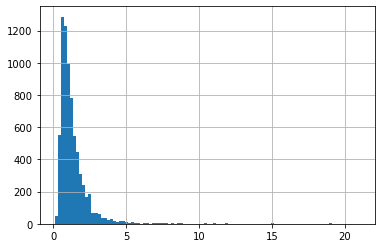

In [15]:
preprocessed_lactate_df.value.hist(bins=100)

In [16]:
inclusion_registry_df.head()

Unnamed: 0              Case ID      Centre Entry date      Entry person  \
3           4   SSR-HUG-1005030884  HUG Genève   20181108  Emmanuel Carrera   
5           6  SSR-HUG-10055644109  HUG Genève   20181002  Emmanuel Carrera   
6           7  SSR-HUG-10057989217  HUG Genève   20180910  Emmanuel Carrera   
11         12  SSR-HUG-10117940030  HUG Genève   20180122    Roman Sztajzel   
12         13  SSR-HUG-10128979104  HUG Genève   20181226  Emmanuel Carrera   

   Patient refuses use of data for research Last name First name       DOB  \
3                                       NaN       NaN        NaN  19331031   
5                                       NaN       NaN        NaN  19570311   
6                                       NaN       NaN        NaN  19500315   
11                                      NaN       NaN        NaN  19210723   
12                                      NaN       NaN        NaN  19270427   

      Type of event  ... 3M Death 3M Death date  \
3   Ischemic stroke  ...       no           NaN   
5   Ischemic stroke  ...       no           NaN   
6   Ischemic stroke  ...       no           NaN   
11  Ischemic stroke  ...      NaN           NaN   
12  Ischemic stroke  ...      yes      20190113   

                             3M Death cause 3M Epileptic seizure  \
3                                       NaN                  NaN   
5                                       NaN                   no   
6                                       NaN                   no   
11                                      NaN                  NaN   
12  Fatal stroke or intracranial hemorrhage                  NaN   

   3M Epileptic seizure date Unnamed: 174 case_admission_id        arrival_dt  \
3                        NaN          NaN       100503_0884  08.11.2018 13:21   
5                        NaN          NaN      1005564_4109  02.10.2018 08:11   
6                        NaN          NaN      1005798_9217  10.09.2018 21:36   
11                       NaN          NaN      1011794_0030  22.01.2018 13:13   
12                       NaN          NaN      1012897_9104  26.12.2018 10:12   

           stroke_dt delta_onset_arrival  
3   08.11.2018 08:30            -17460.0  
5   28.09.2018 00:00           -375060.0  
6   08.09.2018 09:00           -218160.0  
11  22.01.2018 11:30             -6180.0  
12  25.12.2018 18:00            -58320.0  

[5 rows x 179 columns]

In [17]:
inclusion_registry_df['stroke_dt'].isna().sum(), inclusion_registry_df['arrival_dt'].isna().sum()

(24, 0)

In [18]:
inclusion_registry_df['T0'] = inclusion_registry_df['stroke_dt'].fillna(inclusion_registry_df['arrival_dt'])
preprocessed_lactate_df = preprocessed_lactate_df.merge(
    inclusion_registry_df[['case_admission_id', 'T0']],
    on='case_admission_id',
    how='left'
)

In [19]:
dt_format = '%d.%m.%Y %H:%M'
preprocessed_lactate_df['relative_sample_date'] = (pd.to_datetime(preprocessed_lactate_df['sample_date'], format=dt_format) - pd.to_datetime(preprocessed_lactate_df['T0'], format=dt_format)).dt.total_seconds() / 3600 # convert to hours


In [20]:
preprocessed_lactate_df['sample_date'].values

array(['22.09.2018 10:31', '22.09.2018 20:34', '13.08.2018 10:33', ...,
       '01.04.2021 17:40', '14.08.2021 04:11', '14.08.2021 08:45'],
      dtype=object)

In [21]:
import numpy as np
preprocessed_lactate_df['relative_sample_date_hcat'] = preprocessed_lactate_df['relative_sample_date'].apply(np.floor)

In [22]:
preprocessed_lactate_df[['T0', 'sample_date', 'relative_sample_date']]

T0       sample_date  relative_sample_date
0     31.08.2018 10:00  22.09.2018 10:31            528.516667
1     31.08.2018 10:00  22.09.2018 20:34            538.566667
2     22.07.2018 07:45  13.08.2018 10:33            530.800000
3     17.08.2018 19:00  08.09.2018 02:13            511.216667
4     17.08.2018 19:00  08.09.2018 06:02            515.033333
...                ...               ...                   ...
7253  21.03.2021 10:00  01.04.2021 06:16            260.266667
7254  21.03.2021 10:00  01.04.2021 10:49            264.816667
7255  21.03.2021 10:00  01.04.2021 17:40            271.666667
7256  03.08.2021 10:45  14.08.2021 04:11            257.433333
7257  03.08.2021 10:45  14.08.2021 08:45            262.000000

[7258 rows x 3 columns]

In [23]:

# sns.set(style="whitegrid")
# plt.figure(figsize=(10, 6))
# ax = sns.lineplot(x='relative_sample_date_hcat', y='value', data=preprocessed_lactate_df)

# ax.set_xlim(-24, 7*24)

In [24]:
preprocessed_lactate_df.case_admission_id.nunique()

2131

In [25]:
n_patients_with_lactate_in_first_24h = preprocessed_lactate_df[(preprocessed_lactate_df.relative_sample_date > -12) & (preprocessed_lactate_df.relative_sample_date < 24)].case_admission_id.nunique()
n_patients_with_lactate_in_24_to_72h = preprocessed_lactate_df[(preprocessed_lactate_df.relative_sample_date > 24) & (preprocessed_lactate_df.relative_sample_date < 3*24)].case_admission_id.nunique()

print(f'Number of patients with lactate in first 24h: {n_patients_with_lactate_in_first_24h}')
print(f'Number of patients with lactate in 24 to 72h: {n_patients_with_lactate_in_24_to_72h}')

Number of patients with lactate in first 24h: 1821
Number of patients with lactate in 24 to 72h: 467


In [26]:
outcome_df = preprocess_outcomes(registry_path)
outcome_df = outcome_df[outcome_df.case_admission_id.isin(inclusion_registry_df.case_admission_id.unique())]
outcome_df.drop_duplicates(subset='case_admission_id', keep='first', inplace=True)

/Users/jk1/stroke_research/collaterals/outcome_preprocessing.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outcome_df['3M mRS 0-1'] = np.where(outcome_df['3M mRS'].isna(), np.nan, np.where(outcome_df['3M mRS'] <= 1, 1, 0))
/Users/jk1/stroke_research/collaterals/outcome_preprocessing.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outcome_df['3M mRS 0-2'] = np.where(outcome_df['3M mRS'].isna(), np.nan, np.where(outcome_df['3M mRS'] <= 2, 1, 0))


In [27]:
preprocessed_lactate_df = preprocessed_lactate_df.merge(
    outcome_df[['case_admission_id', '3M mRS']],
    on='case_admission_id',
    how='left'
)

In [28]:
preprocessed_lactate_df.head()

patient_id_gc eds_final_patient_id_gc       sample_date analyse_label  \
0            Oui                     Oui  22.09.2018 10:31     G-Lactate   
1            Oui                     Oui  22.09.2018 20:34     G-Lactate   
2  non renseigne           non renseigne  13.08.2018 10:33     G-Lactate   
3  non renseigne           non renseigne  08.09.2018 02:13     G-Lactate   
4  non renseigne           non renseigne  08.09.2018 06:02     G-Lactate   

  dosage_label material_label unit_of_measure  value lower_limit upper_limit  \
0      lactate      any_blood          mmol/l    0.6         0.5         1.6   
1      lactate      any_blood          mmol/l    0.4         0.5         1.6   
2      lactate      any_blood          mmol/l    2.2         NaN         NaN   
3      lactate      any_blood          mmol/l    0.8         0.5         1.6   
4      lactate      any_blood          mmol/l    0.8         0.5         1.6   

  case_admission_id                T0  relative_sample_date  \
0       115383_8908  31.08.2018 10:00            528.516667   
1       115383_8908  31.08.2018 10:00            538.566667   
2       321096_4448  22.07.2018 07:45            530.800000   
3     97186379_4096  17.08.2018 19:00            511.216667   
4     97186379_4096  17.08.2018 19:00            515.033333   

   relative_sample_date_hcat  3M mRS  
0                      528.0     1.0  
1                      538.0     1.0  
2                      530.0     4.0  
3                      511.0     3.0  
4                      515.0     3.0

In [29]:
early_lactate_df = preprocessed_lactate_df[(preprocessed_lactate_df.relative_sample_date > -12) & (preprocessed_lactate_df.relative_sample_date < 24)]
lactate_d2_df = preprocessed_lactate_df[(preprocessed_lactate_df.relative_sample_date > 24) & (preprocessed_lactate_df.relative_sample_date < 2*72)]
lactate_d3_df = preprocessed_lactate_df[(preprocessed_lactate_df.relative_sample_date > 2*24) & (preprocessed_lactate_df.relative_sample_date < 3*72)]
lactate_d_2_3_df = preprocessed_lactate_df[(preprocessed_lactate_df.relative_sample_date > 1*24) & (preprocessed_lactate_df.relative_sample_date < 3*72)]

In [30]:
# correlation of early lactate with outcome
temp_df = early_lactate_df.dropna(subset=['value', '3M mRS'])
corr, p_value = pearsonr(temp_df['value'], temp_df['3M mRS'])
print(f'Pearson correlation: {corr}, p-value: {p_value}')

Pearson correlation: 0.07478534139132387, p-value: 9.212030431816934e-05


In [31]:
# correlation of d2 lactate with outcome
temp_df = lactate_d2_df.dropna(subset=['value', '3M mRS'])
corr, p_value = pearsonr(temp_df['value'], temp_df['3M mRS'])
print(f'Pearson correlation: {corr}, p-value: {p_value}')

Pearson correlation: 0.03538940472350459, p-value: 0.11262165860570118


In [32]:
# correlation of d3 lactate with outcome
temp_df = lactate_d3_df.dropna(subset=['value', '3M mRS'])
corr, p_value = pearsonr(temp_df['value'], temp_df['3M mRS'])
print(f'Pearson correlation: {corr}, p-value: {p_value}')

Pearson correlation: 0.033915847414756825, p-value: 0.18587487864178592


In [33]:
# correlation of d3 lactate with outcome
temp_df = lactate_d_2_3_df.dropna(subset=['value', '3M mRS'])
corr, p_value = pearsonr(temp_df['value'], temp_df['3M mRS'])
print(f'Pearson correlation: {corr}, p-value: {p_value}')

Pearson correlation: 0.036164821432686574, p-value: 0.0770549302852999


In [34]:

mod_log = OrderedModel(temp_df['3M mRS'],
                        temp_df[['value']],
                        distr='logit')

res_log = mod_log.fit()
res_log.summary()

Optimization terminated successfully.
         Current function value: 1.736267
         Iterations: 310
         Function evaluations: 483


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                 3M mRS   Log-Likelihood:                -4151.4
Model:                   OrderedModel   AIC:                             8317.
Method:            Maximum Likelihood   BIC:                             8357.
Date:                Fri, 25 Jul 2025                                         
Time:                        15:22:19                                         
No. Observations:                2391                                         
Df Residuals:                    2384                                         
Df Model:                           1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
value          0.0950      0.040      2.398      0.017       0.017       0.173
0.0/1.0       -2.6339      0.096    -27.361      0.000      -2.823      -2.445
1.0/2.0        0.0945      0.064      1.479      0.139      -0.031       0.220
2.0/3.0       -0.7382      0.072    -10.234      0.000      -0.880      -0.597
3.0/4.0       -0.3867      0.051     -7.579      0.000      -0.487      -0.287
4.0/5.0       -0.5019      0.050    -10.110      0.000      -0.599      -0.405
5.0/6.0       -1.0441      0.067    -15.554      0.000      -1.176      -0.913
==============================================================================
"""

In [35]:
early_lactate_df.describe()

value  relative_sample_date  relative_sample_date_hcat  \
count  3229.000000           3229.000000                3229.000000   
mean      1.525766              9.275606                   8.786621   
std       1.176841              6.687500                   6.692530   
min       0.100000             -1.583333                  -2.000000   
25%       0.900000              3.233333                   3.000000   
50%       1.300000              7.883333                   7.000000   
75%       1.800000             14.400000                  14.000000   
max      21.000000             23.983333                  23.000000   

            3M mRS  
count  2729.000000  
mean      2.901796  
std       2.258876  
min       0.000000  
25%       1.000000  
50%       3.000000  
75%       5.000000  
max       6.000000

adjust form age, NIHSS, mRs

In [36]:
inclusion_registry_df.head()

Unnamed: 0              Case ID      Centre Entry date      Entry person  \
3           4   SSR-HUG-1005030884  HUG Genève   20181108  Emmanuel Carrera   
5           6  SSR-HUG-10055644109  HUG Genève   20181002  Emmanuel Carrera   
6           7  SSR-HUG-10057989217  HUG Genève   20180910  Emmanuel Carrera   
11         12  SSR-HUG-10117940030  HUG Genève   20180122    Roman Sztajzel   
12         13  SSR-HUG-10128979104  HUG Genève   20181226  Emmanuel Carrera   

   Patient refuses use of data for research Last name First name       DOB  \
3                                       NaN       NaN        NaN  19331031   
5                                       NaN       NaN        NaN  19570311   
6                                       NaN       NaN        NaN  19500315   
11                                      NaN       NaN        NaN  19210723   
12                                      NaN       NaN        NaN  19270427   

      Type of event  ... 3M Death date  \
3   Ischemic stroke  ...           NaN   
5   Ischemic stroke  ...           NaN   
6   Ischemic stroke  ...           NaN   
11  Ischemic stroke  ...           NaN   
12  Ischemic stroke  ...      20190113   

                             3M Death cause 3M Epileptic seizure  \
3                                       NaN                  NaN   
5                                       NaN                   no   
6                                       NaN                   no   
11                                      NaN                  NaN   
12  Fatal stroke or intracranial hemorrhage                  NaN   

   3M Epileptic seizure date Unnamed: 174 case_admission_id        arrival_dt  \
3                        NaN          NaN       100503_0884  08.11.2018 13:21   
5                        NaN          NaN      1005564_4109  02.10.2018 08:11   
6                        NaN          NaN      1005798_9217  10.09.2018 21:36   
11                       NaN          NaN      1011794_0030  22.01.2018 13:13   
12                       NaN          NaN      1012897_9104  26.12.2018 10:12   

           stroke_dt delta_onset_arrival                T0  
3   08.11.2018 08:30            -17460.0  08.11.2018 08:30  
5   28.09.2018 00:00           -375060.0  28.09.2018 00:00  
6   08.09.2018 09:00           -218160.0  08.09.2018 09:00  
11  22.01.2018 11:30             -6180.0  22.01.2018 11:30  
12  25.12.2018 18:00            -58320.0  25.12.2018 18:00  

[5 rows x 180 columns]

In [37]:
inclusion_registry_df['age'] = inclusion_registry_df['Age (calc.)']
# covariates = ['age', 'Prestroke disability (Rankin)', 'NIH on admission']
covariates = ['age', 'NIH on admission']
preprocessed_lactate_df = preprocessed_lactate_df.merge(
    inclusion_registry_df[['case_admission_id'] + covariates],
    on='case_admission_id',
    how='left'
)

In [38]:
early_lactate_df = preprocessed_lactate_df[(preprocessed_lactate_df.relative_sample_date > -12) & (preprocessed_lactate_df.relative_sample_date < 24)]
lactate_d2_df = preprocessed_lactate_df[(preprocessed_lactate_df.relative_sample_date > 24) & (preprocessed_lactate_df.relative_sample_date < 2*72)]
lactate_d3_df = preprocessed_lactate_df[(preprocessed_lactate_df.relative_sample_date > 2*24) & (preprocessed_lactate_df.relative_sample_date < 3*72)]
lactate_d_2_3_df = preprocessed_lactate_df[(preprocessed_lactate_df.relative_sample_date > 1*24) & (preprocessed_lactate_df.relative_sample_date < 3*72)]

In [39]:
# overall lactate vs mrs adjusted for covariates
temp_df = preprocessed_lactate_df[['value', '3M mRS'] + covariates]
temp_df.dropna(inplace=True)
# set all vars to float
temp_df = temp_df.astype(float)

all_data_mod_log = OrderedModel(temp_df['3M mRS'],
                        temp_df[['value'] + covariates],
                        distr='logit')

all_data_res_log = all_data_mod_log.fit()
all_data_res_log.summary()

/var/folders/9v/1s329cwj32jc2kkx24p8jp980000gp/T/ipykernel_14516/3190176849.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.dropna(inplace=True)
/Users/jk1/opt/anaconda3/envs/opsum/lib/python3.8/site-packages/statsmodels/base/optimizer.py:736: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/Users/jk1/opt/anaconda3/envs/opsum/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                 3M mRS   Log-Likelihood:                -10492.
Model:                   OrderedModel   AIC:                         2.100e+04
Method:            Maximum Likelihood   BIC:                         2.106e+04
Date:                Fri, 25 Jul 2025                                         
Time:                        15:22:20                                         
No. Observations:                6056                                         
Df Residuals:                    6047                                         
Df Model:                           3                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
value               -0.0643      0.024     -2.634      0.008      -0.112      -0.016
age                  0.0238      0.002     14.898      0.000       0.021       0.027
NIH on admission     0.0981      0.003     32.619      0.000       0.092       0.104
0.0/1.0              0.4644      0.123      3.782      0.000       0.224       0.705
1.0/2.0              0.1006      0.031      3.273      0.001       0.040       0.161
2.0/3.0             -0.6471      0.040    -16.222      0.000      -0.725      -0.569
3.0/4.0             -0.4173      0.033    -12.611      0.000      -0.482      -0.352
4.0/5.0             -0.3967      0.032    -12.229      0.000      -0.460      -0.333
5.0/6.0             -1.2166      0.052    -23.384      0.000      -1.319      -1.115
====================================================================================
"""

In [40]:
# day 1
temp_df = early_lactate_df[['value', '3M mRS'] + covariates]
temp_df.dropna(inplace=True)
# set all vars to float
temp_df = temp_df.astype(float)

all_data_mod_log = OrderedModel(temp_df['3M mRS'],
                        temp_df[['value'] + covariates],
                        distr='logit')

all_data_res_log = all_data_mod_log.fit()
all_data_res_log.summary()

/var/folders/9v/1s329cwj32jc2kkx24p8jp980000gp/T/ipykernel_14516/140342734.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.dropna(inplace=True)
/Users/jk1/opt/anaconda3/envs/opsum/lib/python3.8/site-packages/statsmodels/base/optimizer.py:736: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/Users/jk1/opt/anaconda3/envs/opsum/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                 3M mRS   Log-Likelihood:                -4439.6
Model:                   OrderedModel   AIC:                             8897.
Method:            Maximum Likelihood   BIC:                             8950.
Date:                Fri, 25 Jul 2025                                         
Time:                        15:22:21                                         
No. Observations:                2608                                         
Df Residuals:                    2599                                         
Df Model:                           3                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
value                0.0258      0.034      0.752      0.452      -0.041       0.093
age                  0.0373      0.002     15.013      0.000       0.032       0.042
NIH on admission     0.1018      0.005     22.502      0.000       0.093       0.111
0.0/1.0              2.2664      0.195     11.636      0.000       1.885       2.648
1.0/2.0             -0.1716      0.048     -3.551      0.000      -0.266      -0.077
2.0/3.0             -0.4969      0.055     -9.101      0.000      -0.604      -0.390
3.0/4.0             -0.4291      0.052     -8.194      0.000      -0.532      -0.326
4.0/5.0             -0.3793      0.053     -7.113      0.000      -0.484      -0.275
5.0/6.0             -1.2876      0.092    -14.027      0.000      -1.468      -1.108
====================================================================================
"""

In [41]:
# day 2-3
temp_df = lactate_d_2_3_df[['value', '3M mRS'] + covariates]
temp_df.dropna(inplace=True)
# set all vars to float
temp_df = temp_df.astype(float)

all_data_mod_log = OrderedModel(temp_df['3M mRS'],
                        temp_df[['value'] + covariates],
                        distr='logit')

all_data_res_log = all_data_mod_log.fit()
all_data_res_log.summary()

/var/folders/9v/1s329cwj32jc2kkx24p8jp980000gp/T/ipykernel_14516/2277983882.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.dropna(inplace=True)
/Users/jk1/opt/anaconda3/envs/opsum/lib/python3.8/site-packages/statsmodels/base/optimizer.py:736: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/Users/jk1/opt/anaconda3/envs/opsum/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                 3M mRS   Log-Likelihood:                -3697.5
Model:                   OrderedModel   AIC:                             7413.
Method:            Maximum Likelihood   BIC:                             7464.
Date:                Fri, 25 Jul 2025                                         
Time:                        15:22:21                                         
No. Observations:                2219                                         
Df Residuals:                    2210                                         
Df Model:                           3                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
value               -0.1181      0.045     -2.612      0.009      -0.207      -0.029
age                  0.0250      0.003      9.551      0.000       0.020       0.030
NIH on admission     0.0659      0.005     14.493      0.000       0.057       0.075
0.0/1.0             -0.4308      0.206     -2.095      0.036      -0.834      -0.028
1.0/2.0              0.1033      0.066      1.566      0.117      -0.026       0.233
2.0/3.0             -0.8249      0.083     -9.888      0.000      -0.988      -0.661
3.0/4.0             -0.2017      0.051     -3.956      0.000      -0.302      -0.102
4.0/5.0             -0.3389      0.050     -6.847      0.000      -0.436      -0.242
5.0/6.0             -1.0081      0.071    -14.145      0.000      -1.148      -0.868
====================================================================================
"""

In [ ]:
# day 2-3 (mrs 0-2 vs 3-6)


/var/folders/9v/1s329cwj32jc2kkx24p8jp980000gp/T/ipykernel_14516/2543611263.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  early_lactate_df['mRS_binary'] = (early_lactate_df['3M mRS'] <= 2).astype(int)
/var/folders/9v/1s329cwj32jc2kkx24p8jp980000gp/T/ipykernel_14516/2543611263.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lactate_d_2_3_df['mRS_binary'] = (lactate_d_2_3_df['3M mRS'] <= 2).astype(int)


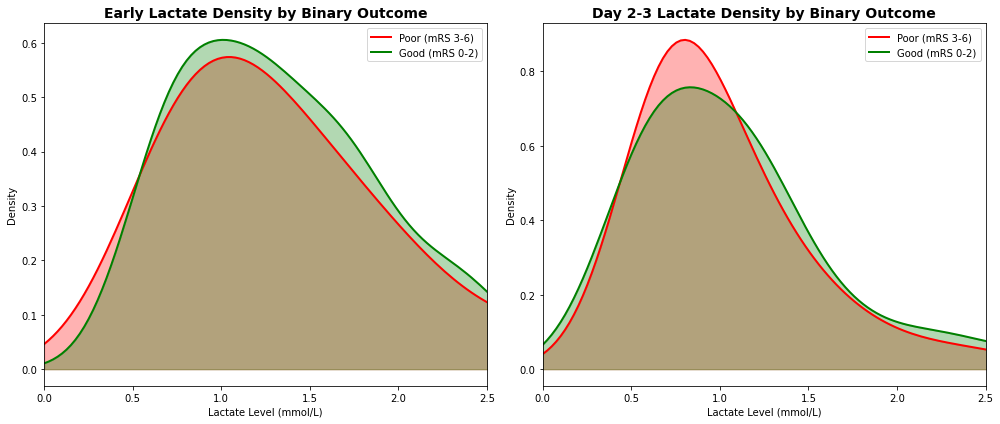

In [ ]:
# VISUALIZATION: Binary density plots only (0-5 range)
from scipy.stats import gaussian_kde

# Create binary mRS outcome (0-2 vs 3-6)
early_lactate_df['mRS_binary'] = (early_lactate_df['3M mRS'] <= 2).astype(int)
lactate_d_2_3_df['mRS_binary'] = (lactate_d_2_3_df['3M mRS'] <= 2).astype(int)

# Use data without outlier removal
early_clean = early_lactate_df.dropna(subset=['value', '3M mRS'])
d23_clean = lactate_d_2_3_df.dropna(subset=['value', '3M mRS'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Binary outcomes setup
binary_outcomes = [0, 1]
binary_labels = ['Poor (mRS 3-6)', 'Good (mRS 0-2)']
colors_binary = ['red', 'green']

# Early lactate - binary mRS
for i, (outcome, label, color) in enumerate(zip(binary_outcomes, binary_labels, colors_binary)):
    subset = early_clean[early_clean['mRS_binary'] == outcome]['value']
    if len(subset) > 1:
        density = gaussian_kde(subset)
        xs = np.linspace(0, 5, 200)  # Concentrated on 0-5 range
        density_values = density(xs)
        # Plot density curves with proper scaling
        axes[0].plot(xs, density_values, color=color, linewidth=2, label=label)
        axes[0].fill_between(xs, 0, density_values, alpha=0.3, color=color)

axes[0].set_title('Early Lactate Density by Binary Outcome', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lactate Level (mmol/L)')
axes[0].set_ylabel('Density')
axes[0].set_xlim(0, 5)
axes[0].legend()

# Day 2-3 lactate - binary mRS
for i, (outcome, label, color) in enumerate(zip(binary_outcomes, binary_labels, colors_binary)):
    subset = d23_clean[d23_clean['mRS_binary'] == outcome]['value']
    if len(subset) > 1:
        density = gaussian_kde(subset)
        xs = np.linspace(0, 5, 200)  # Concentrated on 0-5 range
        density_values = density(xs)
        # Plot density curves with proper scaling
        axes[1].plot(xs, density_values, color=color, linewidth=2, label=label)
        axes[1].fill_between(xs, 0, density_values, alpha=0.3, color=color)

axes[1].set_title('Day 2-3 Lactate Density by Binary Outcome', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lactate Level (mmol/L)')
axes[1].set_ylabel('Density')
axes[1].set_xlim(0, 5)
axes[1].legend()

plt.tight_layout()
plt.show()

/var/folders/9v/1s329cwj32jc2kkx24p8jp980000gp/T/ipykernel_48002/1229724053.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  early_clean['mRS_str'] = early_clean['3M mRS'].astype(int).astype(str)
/var/folders/9v/1s329cwj32jc2kkx24p8jp980000gp/T/ipykernel_48002/1229724053.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d23_clean['mRS_str'] = d23_clean['3M mRS'].astype(int).astype(str)
/var/folders/9v/1s329cwj32jc2kkx24p8jp980000gp/T/ipykernel_48002/1229724053.py:21: SettingWithCopyWarning: 
A value 

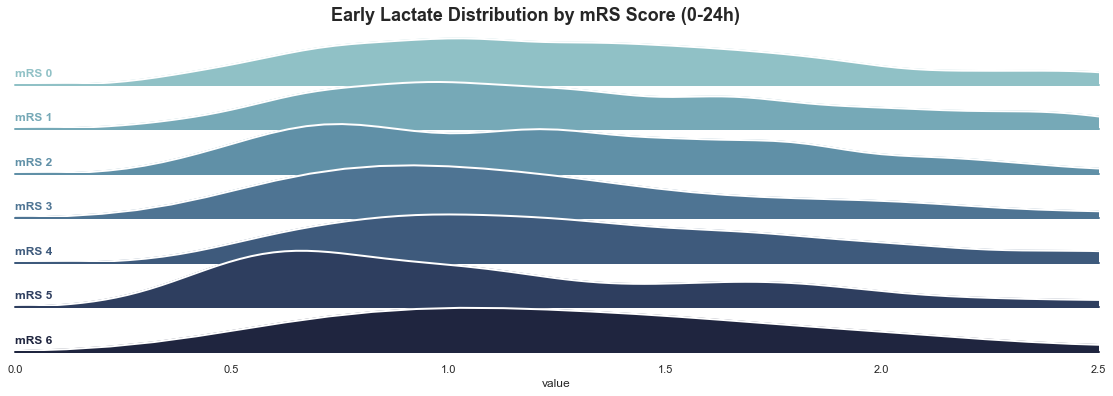

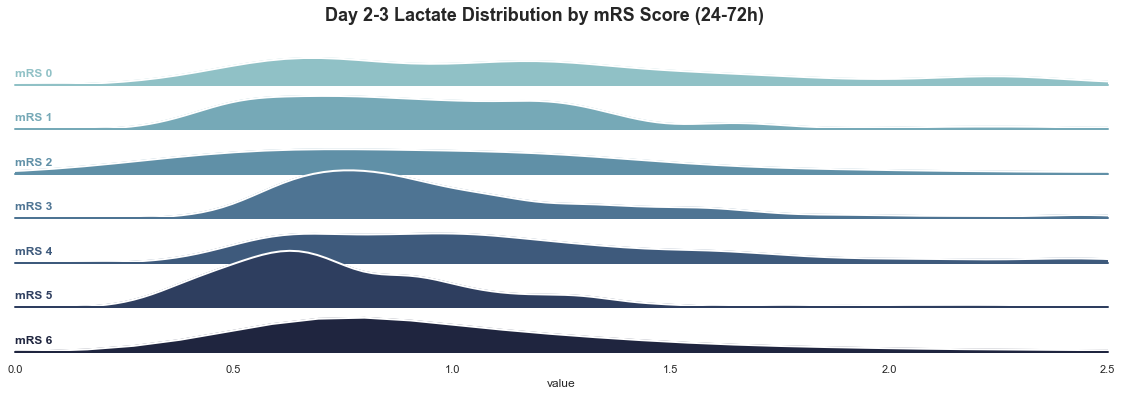

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

x_max = 2.5  # Set x-axis limit for ridge plots

# Set the style for ridge plots
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Prepare data for ridge plots
early_clean = early_lactate_df.dropna(subset=['value', '3M mRS'])
d23_clean = lactate_d_2_3_df.dropna(subset=['value', '3M mRS'])

# Convert mRS to string for proper ordering - SORT PROPERLY
early_clean['mRS_str'] = early_clean['3M mRS'].astype(int).astype(str)
d23_clean['mRS_str'] = d23_clean['3M mRS'].astype(int).astype(str)

# Create ordered categories for proper sorting
mrs_categories = ['0', '1', '2', '3', '4', '5', '6']
early_clean['mRS_str'] = pd.Categorical(early_clean['mRS_str'], categories=mrs_categories, ordered=True)
d23_clean['mRS_str'] = pd.Categorical(d23_clean['mRS_str'], categories=mrs_categories, ordered=True)

# Define function to label the plot
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, f"mRS {label}", fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

# Ridge plot for Early Lactate - BIGGER SIZE
pal = sns.cubehelix_palette(len(early_clean['mRS_str'].cat.categories), rot=-.25, light=.7)
g1 = sns.FacetGrid(early_clean, row="mRS_str", hue="mRS_str", aspect=20, height=.8, palette=pal, row_order=mrs_categories)

# Draw the densities
g1.map(sns.kdeplot, "value",
      bw_adjust=.5, clip_on=True,
      fill=True, alpha=1, linewidth=1.5)
g1.map(sns.kdeplot, "value", clip_on=True, color="w", lw=2, bw_adjust=.5)

# Add reference line
g1.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

g1.map(label, "value")

# Set the subplots to overlap
g1.figure.subplots_adjust(hspace=-.25)

# Remove axes details
g1.set_titles("")
g1.set(yticks=[], ylabel="")
g1.despine(bottom=True, left=True)

# Set x-axis limits to focus on 0-3
g1.set(xlim=(0, x_max))

# Add main title with larger font
g1.figure.suptitle('Early Lactate Distribution by mRS Score (0-24h)', 
                   fontsize=18, fontweight='bold', y=0.98)

plt.show()

# Ridge plot for Day 2-3 Lactate - BIGGER SIZE
pal2 = sns.cubehelix_palette(len(d23_clean['mRS_str'].cat.categories), rot=-.25, light=.7)
g2 = sns.FacetGrid(d23_clean, row="mRS_str", hue="mRS_str", aspect=20, height=.8, palette=pal2, row_order=mrs_categories)

# Draw the densities
g2.map(sns.kdeplot, "value",
      bw_adjust=.5, clip_on=True,
      fill=True, alpha=1, linewidth=1.5)
g2.map(sns.kdeplot, "value", clip_on=True, color="w", lw=2, bw_adjust=.5)

# Add reference line
g2.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

g2.map(label, "value")

# Set the subplots to overlap
g2.figure.subplots_adjust(hspace=-.25)

# Remove axes details
g2.set_titles("")
g2.set(yticks=[], ylabel="")
g2.despine(bottom=True, left=True)

# Set x-axis limits to focus on 0-3
g2.set(xlim=(0, x_max))

# Add main title with larger font
g2.figure.suptitle('Day 2-3 Lactate Distribution by mRS Score (24-72h)', 
                   fontsize=18, fontweight='bold', y=0.98)

plt.show()

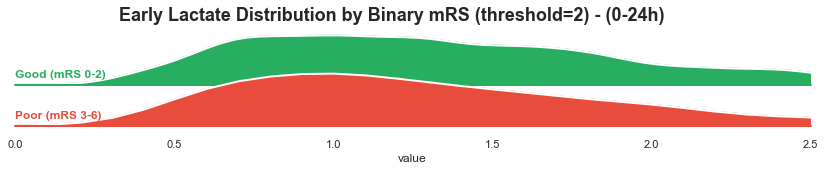

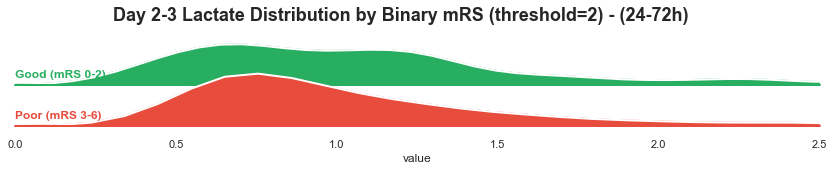


SUMMARY STATISTICS (threshold=2):

EARLY LACTATE:
Good outcome (mRS 0-2): N=1286, median=1.30 ± 0.80
Poor outcome (mRS 3-6): N=1443, median=1.30 ± 1.40
Good outcome rate: 47.1%

DAY 2-3 LACTATE:
Good outcome (mRS 0-2): N=569, median=1.00 ± 0.91
Poor outcome (mRS 3-6): N=1822, median=0.90 ± 1.12
Good outcome rate: 23.8%


In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_dichotomized_ridge_plots(early_lactate_df, lactate_d_2_3_df, threshold=2, x_max=2.5):
    """
    Create dichotomized ridge plots for mRS outcomes with variable threshold.
    
    Parameters:
    - early_lactate_df: DataFrame with early lactate data
    - lactate_d_2_3_df: DataFrame with day 2-3 lactate data
    - threshold: mRS threshold for dichotomization (default=2, creates 0-2 vs 3-6)
    - x_max: Maximum x-axis limit for plots
    """
    aspect_ratio = 10
    
    # Set the style for ridge plots
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    # Prepare data for ridge plots
    early_clean = early_lactate_df.dropna(subset=['value', '3M mRS']).copy()
    d23_clean = lactate_d_2_3_df.dropna(subset=['value', '3M mRS']).copy()

    # Create dichotomized mRS outcome based on threshold
    early_clean['mRS_binary'] = (early_clean['3M mRS'] <= threshold).astype(int)
    d23_clean['mRS_binary'] = (d23_clean['3M mRS'] <= threshold).astype(int)

    # Create categorical labels for binary outcomes
    early_clean['mRS_binary_str'] = early_clean['mRS_binary'].map({
        0: f'Poor (mRS {threshold+1}-6)', 
        1: f'Good (mRS 0-{threshold})'
    })
    d23_clean['mRS_binary_str'] = d23_clean['mRS_binary'].map({
        0: f'Poor (mRS {threshold+1}-6)', 
        1: f'Good (mRS 0-{threshold})'
    })

    # Create ordered categories for proper sorting (Good outcome first, then Poor)
    binary_categories = [f'Good (mRS 0-{threshold})', f'Poor (mRS {threshold+1}-6)']
    early_clean['mRS_binary_str'] = pd.Categorical(
        early_clean['mRS_binary_str'], 
        categories=binary_categories, 
        ordered=True
    )
    d23_clean['mRS_binary_str'] = pd.Categorical(
        d23_clean['mRS_binary_str'], 
        categories=binary_categories, 
        ordered=True
    )

    # Define function to label the plot
    def label_binary(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    # Create color palette for binary outcomes
    colors = ['#27ae60', '#e74c3c']  # Green for good, red for poor
    
    # Ridge plot for Early Lactate - Dichotomized
    g1 = sns.FacetGrid(early_clean, row="mRS_binary_str", hue="mRS_binary_str", 
                       aspect=aspect_ratio, height=1.2, palette=colors, row_order=binary_categories)

    # Draw the densities
    g1.map(sns.kdeplot, "value",
          bw_adjust=.5, clip_on=True,
          fill=True, alpha=1, linewidth=1.5)
    g1.map(sns.kdeplot, "value", clip_on=True, color="w", lw=2, bw_adjust=.5)

    # Add reference line
    g1.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

    g1.map(label_binary, "value")

    # Set the subplots to overlap
    g1.figure.subplots_adjust(hspace=-.25)

    # Remove axes details
    g1.set_titles("")
    g1.set(yticks=[], ylabel="")
    g1.despine(bottom=True, left=True)

    # Set x-axis limits
    g1.set(xlim=(0, x_max))

    # Add main title with larger font
    g1.figure.suptitle(f'Early Lactate Distribution by Binary mRS (threshold={threshold}) - (0-24h)', 
                       fontsize=18, fontweight='bold', y=0.98)

    plt.show()

    # Ridge plot for Day 2-3 Lactate - Dichotomized
    g2 = sns.FacetGrid(d23_clean, row="mRS_binary_str", hue="mRS_binary_str", 
                       aspect=aspect_ratio, height=1.2, palette=colors, row_order=binary_categories)

    # Draw the densities
    g2.map(sns.kdeplot, "value",
          bw_adjust=.5, clip_on=True,
          fill=True, alpha=1, linewidth=1.5)
    g2.map(sns.kdeplot, "value", clip_on=True, color="w", lw=2, bw_adjust=.5)

    # Add reference line
    g2.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

    g2.map(label_binary, "value")

    # Set the subplots to overlap
    g2.figure.subplots_adjust(hspace=-.25)

    # Remove axes details
    g2.set_titles("")
    g2.set(yticks=[], ylabel="")
    g2.despine(bottom=True, left=True)

    # Set x-axis limits
    g2.set(xlim=(0, x_max))

    # Add main title with larger font
    g2.figure.suptitle(f'Day 2-3 Lactate Distribution by Binary mRS (threshold={threshold}) - (24-72h)', 
                       fontsize=18, fontweight='bold', y=0.98)

    plt.show()

    # Print summary statistics
    print(f"\nSUMMARY STATISTICS (threshold={threshold}):")
    print("="*50)
    
    # Early lactate summary
    early_good = early_clean[early_clean['mRS_binary'] == 1]
    early_poor = early_clean[early_clean['mRS_binary'] == 0]
    
    print(f"\nEARLY LACTATE:")
    print(f"Good outcome (mRS 0-{threshold}): N={len(early_good)}, median={early_good['value'].median():.2f} ± {early_good['value'].std():.2f}")
    print(f"Poor outcome (mRS {threshold+1}-6): N={len(early_poor)}, median={early_poor['value'].median():.2f} ± {early_poor['value'].std():.2f}")
    print(f"Good outcome rate: {(early_clean['mRS_binary'] == 1).mean()*100:.1f}%")
    
    # Day 2-3 lactate summary
    d23_good = d23_clean[d23_clean['mRS_binary'] == 1]
    d23_poor = d23_clean[d23_clean['mRS_binary'] == 0]
    
    print(f"\nDAY 2-3 LACTATE:")
    print(f"Good outcome (mRS 0-{threshold}): N={len(d23_good)}, median={d23_good['value'].median():.2f} ± {d23_good['value'].std():.2f}")
    print(f"Poor outcome (mRS {threshold+1}-6): N={len(d23_poor)}, median={d23_poor['value'].median():.2f} ± {d23_poor['value'].std():.2f}")
    print(f"Good outcome rate: {(d23_clean['mRS_binary'] == 1).mean()*100:.1f}%")

# Usage examples:
# Default threshold of 2 (mRS 0-2 vs 3-6)
create_dichotomized_ridge_plots(early_lactate_df, lactate_d_2_3_df, threshold=2)

# Alternative threshold of 1 (mRS 0-1 vs 2-6)
# create_dichotomized_ridge_plots(early_lactate_df, lactate_d_2_3_df, threshold=1)

# Alternative threshold of 3 (mRS 0-3 vs 4-6)
# create_dichotomized_ridge_plots(early_lactate_df, lactate_d_2_3_df, threshold=3)

/var/folders/9v/1s329cwj32jc2kkx24p8jp980000gp/T/ipykernel_48002/2086056834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  early_lactate_df['mRS_binary'] = (early_lactate_df['3M mRS'] <= 2).astype(int)
/var/folders/9v/1s329cwj32jc2kkx24p8jp980000gp/T/ipykernel_48002/2086056834.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lactate_d_2_3_df['mRS_binary'] = (lactate_d_2_3_df['3M mRS'] <= 2).astype(int)
/var/folders/9v/1s329cwj32jc2kkx24p8jp980000gp/T/ipykernel_48002/2086056834.py:6: SettingWithCopyW

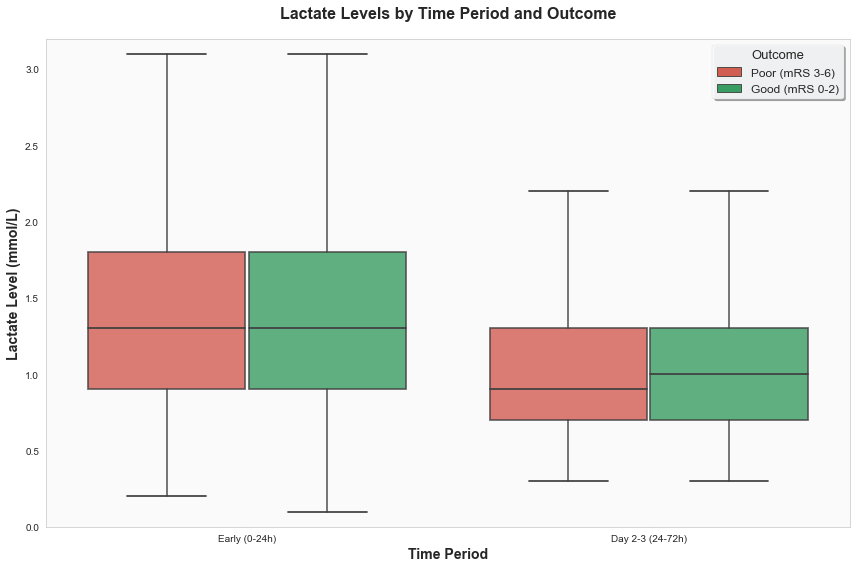

In [ ]:
# Create binary mRS outcome (0-2 vs 3-6)
early_lactate_df['mRS_binary'] = (early_lactate_df['3M mRS'] <= 2).astype(int)
lactate_d_2_3_df['mRS_binary'] = (lactate_d_2_3_df['3M mRS'] <= 2).astype(int)

# Create binary outcome labels
early_lactate_df['outcome_label'] = early_lactate_df['mRS_binary'].map({0: 'Poor (mRS 3-6)', 1: 'Good (mRS 0-2)'})
lactate_d_2_3_df['outcome_label'] = lactate_d_2_3_df['mRS_binary'].map({0: 'Poor (mRS 3-6)', 1: 'Good (mRS 0-2)'})

# Add time period labels
early_lactate_df['time_period'] = 'Early (0-24h)'
lactate_d_2_3_df['time_period'] = 'Day 2-3 (24-72h)'

# Combine datasets
combined_df = pd.concat([early_lactate_df, lactate_d_2_3_df], ignore_index=True)

# Create the combined plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Define vibrant colors for outcomes
outcome_colors = {
    'Poor (mRS 3-6)': '#e74c3c',    # Red for poor outcomes
    'Good (mRS 0-2)': '#27ae60'     # Green for good outcomes
}

# Create boxplot with time periods on x-axis and outcomes as hue
sns.boxplot(x='time_period', y='value', hue='outcome_label', data=combined_df, 
            ax=ax, showfliers=False, palette=outcome_colors,
            boxprops=dict(alpha=0.8), whiskerprops=dict(alpha=0.8))

# Style improvements
ax.set_title('Lactate Levels by Time Period and Outcome', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Time Period', fontsize=14, fontweight='bold')
ax.set_ylabel('Lactate Level (mmol/L)', fontsize=14, fontweight='bold')
ax.set_ylim(0, 3.2)

# Improve legend with better styling
legend = ax.legend(title='Outcome', title_fontsize=13, fontsize=12, 
                  loc='upper right', frameon=True, fancybox=True, shadow=True)
legend.get_frame().set_facecolor('#f8f9fa')
legend.get_frame().set_alpha(0.9)

# Add subtle grid for better readability
ax.grid(True, alpha=0.3, linestyle='--')

# Make the plot background slightly off-white
ax.set_facecolor('#fafafa')

# Style the spines
for spine in ax.spines.values():
    spine.set_color('#cccccc')
    spine.set_linewidth(0.8)

plt.tight_layout()
plt.show()

In [46]:
os.environ["R_HOME"] = "/Library/Frameworks/R.framework/Versions/4.1/Resources"
from pymer4.models import Lmer

# overall lactate vs mrs adjusted for covariates
temp_df = preprocessed_lactate_df[['value', '3M mRS', 'case_admission_id'] + covariates]
# replace all ' ' in columns names with _
temp_df.columns = temp_df.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
covariates_with_underscore = [covar_name.replace(' ', '_').replace('(', '').replace(')', '') for covar_name in covariates]
temp_df['mrs'] = temp_df['3M_mRS']

model = Lmer(f'mrs ~ value + {" + ".join(covariates_with_underscore)} + (1|case_admission_id)',
             data=temp_df)
# model.fit(control='optimizer="bobyqa", optCtrl=list(maxfun=100000)')
model.fit()
print(model.summary())



/var/folders/9v/1s329cwj32jc2kkx24p8jp980000gp/T/ipykernel_48002/2636111682.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp_df.columns = temp_df.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
/var/folders/9v/1s329cwj32jc2kkx24p8jp980000gp/T/ipykernel_48002/2636111682.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp_df.columns = temp_df.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
/var/folders/9v/1s329cwj32jc2kkx24p8jp980000gp/T/ipykernel_48002/2636111682.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

[1] "Model failed to converge with max|grad| = 0.00725 (tol = 0.002, component 1)"
[2] " \n"                                                                         

[1] "Model is nearly unidentifiable: very large eigenvalue\n - Rescale variables?"
[2] " \n"                                                                         

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by REML [’lmerMod’]
Formula: mrs~value+age+NIH_on_admission+(1|case_admission_id)

Family: gaussian	 Inference: parametric

Number of observations: 7258	 Groups: {'case_admission_id': 1819.0}

Log-likelihood: 37882.647 	 AIC: -74597.294

Random effects:

                          Name    Var    Std
case_admission_id  (Intercept)  0.735  0.857
Residual     

In [ ]:
# overall lactate vs mrs adjusted for covariates
temp_df = early_lactate_df[['value', '3M mRS', 'case_admission_id'] + covariates]
# replace all ' ' in columns names with _
temp_df.columns = temp_df.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
covariates_with_underscore = [covar_name.replace(' ', '_').replace('(', '').replace(')', '') for covar_name in covariates]
temp_df['mrs'] = temp_df['3M_mRS']

model = Lmer(f'mrs ~ value + {" + ".join(covariates_with_underscore)} + (1|case_admission_id)',
             data=temp_df)
model.fit(control='optimizer="bobyqa", optCtrl=list(maxfun=100000)')
# model.fit()
print(model.summary())

/var/folders/9v/1s329cwj32jc2kkx24p8jp980000gp/T/ipykernel_48002/3660559814.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp_df.columns = temp_df.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
/var/folders/9v/1s329cwj32jc2kkx24p8jp980000gp/T/ipykernel_48002/3660559814.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp_df.columns = temp_df.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
/var/folders/9v/1s329cwj32jc2kkx24p8jp980000gp/T/ipykernel_48002/3660559814.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

unable to evaluate scaled gradient 

Model failed to converge: degenerate  Hessian with 1 negative eigenvalues 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by REML [’lmerMod’]
Formula: mrs~value+age+NIH_on_admission+(1|case_admission_id)

Family: gaussian	 Inference: parametric

Number of observations: 3229	 Groups: {'case_admission_id': 1539.0}

Log-likelihood: 7346.157 	 AIC: -13564.313

Random effects:

                          Name    Var    Std
case_admission_id  (Intercept)  1.547  1.244
Residual                        0.000  0.000

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: mrs~value+age+NIH_on_admission+(1|case_admission_id)

Family: gaussian	 Inferenc

In [48]:
# overall lactate vs mrs adjusted for covariates
temp_df = lactate_d_2_3_df[['value', '3M mRS', 'case_admission_id'] + covariates]
# replace all ' ' in columns names with _
temp_df.columns = temp_df.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
covariates_with_underscore = [covar_name.replace(' ', '_').replace('(', '').replace(')', '') for covar_name in covariates]
temp_df['mrs'] = temp_df['3M_mRS']
temp_df.dropna(subset=['value', 'mrs'] + covariates_with_underscore, inplace=True)
model = Lmer(f'mrs ~ value + {" + ".join(covariates_with_underscore)} + (1|case_admission_id)',
             data=temp_df)
# model.fit(control='optimizer="bobyqa", optCtrl=list(maxfun=100000)')
# increase tolerance
model.fit(control='optimizer="nlminbwrap", optCtrl=list(maxfun=100000, xtol_abs = 1e-12, ftol_abs = 1e-12)')

print(model.summary())

/var/folders/9v/1s329cwj32jc2kkx24p8jp980000gp/T/ipykernel_48002/2168025672.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp_df.columns = temp_df.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
/var/folders/9v/1s329cwj32jc2kkx24p8jp980000gp/T/ipykernel_48002/2168025672.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp_df.columns = temp_df.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
/var/folders/9v/1s329cwj32jc2kkx24p8jp980000gp/T/ipykernel_48002/2168025672.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

[1] "unrecognized control elements named ‘xtol_abs’, ‘ftol_abs’ ignored"
[2] " \n"                                                               

[1] "Model failed to converge with max|grad| = 0.0189131 (tol = 0.002, component 1)"
[2] " \n"                                                                           

[1] "Model is nearly unidentifiable: very large eigenvalue\n - Rescale variables?"
[2] " \n"                                                                         

Linear mixed model fit by REML [’lmerMod’]
Formula: mrs~value+age+NIH_on_admission+(1|case_admission_id)

Family: gaussian	 Inference: parametric

Number of observations: 2219	 Groups: {'case_admission_id': 495.0}

Log-likelihood: 17809.660 	 AIC: -34961.321

Random effects:

                          Name    Var    Std
case_admission_id  (Intercept)  0.329  0.574
Residual                        0.000  0.000

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Fo